In [1]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANDL/Homework_1

Mounted at /gdrive
/gdrive/My Drive/ANDL/Homework_1


In [4]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [6]:
# Dataset folders 
dataset_dir = 'atMost700'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8',]

Text(0.5, 1.0, 'Number of training images per category:')

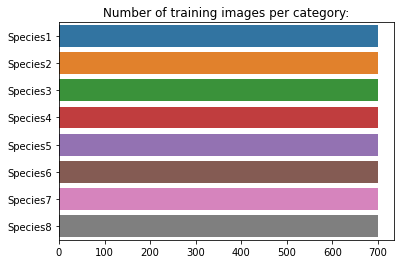

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(#rotation_range=180,
                                        height_shift_range=5,
                                        width_shift_range=5,
                                        #zoom_range=0.5,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        #fill_mode='nearest',
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. not on vgg16
                                        ) 
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

In [9]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 5600 images belonging to 8 classes.
Found 527 images belonging to 8 classes.
Found 361 images belonging to 8 classes.


In [10]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (32, 96, 96, 3)
Target shape: (32, 8)

Categorical label: [0. 0. 0. 0. 0. 0. 1. 0.]
Label: 6
Class name: Species7


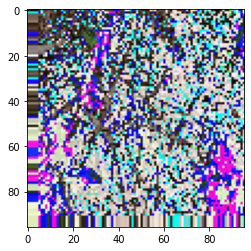

In [11]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

In [13]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('Vgg19')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [ ]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [15]:
input_shape = (96, 96, 3)
epochs = 200

In [16]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
# No resize
#x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [18]:
for i, layer in enumerate(tl_model.get_layer('vgg19').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 False
18 block5_conv2 False
19 block5_conv3 False
20 block5_conv4 False
21 block5_pool False


In [19]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = tl_callbacks,
    #class_weight=class_weight
).history

Epoch 1/200
175/175 [==============================] - ETA: 0s - loss: 3.0337 - accuracy: 0.3914 - precision: 0.4618 - recall: 0.2886 

175/175 [==============================] - 3637s 21s/step - loss: 3.0337 - accuracy: 0.3914 - precision: 0.4618 - recall: 0.2886 - val_loss: 1.3099 - val_accuracy: 0.4972 - val_precision: 0.7273 - val_recall: 0.2884
Epoch 2/200
175/175 [==============================] - ETA: 0s - loss: 1.3807 - accuracy: 0.5025 - precision: 0.6518 - recall: 0.3516

175/175 [==============================] - 32s 180ms/step - loss: 1.3807 - accuracy: 0.5025 - precision: 0.6518 - recall: 0.3516 - val_loss: 1.2160 - val_accuracy: 0.5408 - val_precision: 0.6886 - val_recall: 0.3567
Epoch 3/200
175/175 [==============================] - ETA: 0s - loss: 1.2178 - accuracy: 0.5516 - precision: 0.6790 - recall: 0.4098

175/175 [==============================] - 31s 179ms/step - loss: 1.2178 - accuracy: 0.5516 - precision: 0.6790 - recall: 0.4098 - val_loss: 1.1591 - val_accuracy: 0.5863 - val_precision: 0.6767 - val_recall: 0.4250
Epoch 4/200
175/175 [==============================] - ETA: 0s - loss: 1.1277 - accuracy: 0.5918 - precision: 0.7135 - recall: 0.4655

175/175 [==============================] - 31s 176ms/step - loss: 1.1277 - accuracy: 0.5918 - precision: 0.7135 - recall: 0.4655 - val_loss: 1.1191 - val_accuracy: 0.5958 - val_precision: 0.6875 - val_recall: 0.4592
Epoch 5/200
175/175 [==============================] - ETA: 0s - loss: 1.0719 - accuracy: 0.6127 - precision: 0.7347 - recall: 0.4920

175/175 [==============================] - 31s 179ms/step - loss: 1.0719 - accuracy: 0.6127 - precision: 0.7347 - recall: 0.4920 - val_loss: 1.1038 - val_accuracy: 0.6167 - val_precision: 0.7066 - val_recall: 0.4706
Epoch 6/200
175/175 [==============================] - ETA: 0s - loss: 1.0175 - accuracy: 0.6316 - precision: 0.7385 - recall: 0.5104

175/175 [==============================] - 31s 177ms/step - loss: 1.0175 - accuracy: 0.6316 - precision: 0.7385 - recall: 0.5104 - val_loss: 1.0777 - val_accuracy: 0.6110 - val_precision: 0.7116 - val_recall: 0.5009
Epoch 7/200
175/175 [==============================] - ETA: 0s - loss: 0.9651 - accuracy: 0.6443 - precision: 0.7528 - recall: 0.5395

175/175 [==============================] - 32s 181ms/step - loss: 0.9651 - accuracy: 0.6443 - precision: 0.7528 - recall: 0.5395 - val_loss: 1.0562 - val_accuracy: 0.6224 - val_precision: 0.7057 - val_recall: 0.4915
Epoch 8/200
175/175 [==============================] - ETA: 0s - loss: 0.9301 - accuracy: 0.6559 - precision: 0.7623 - recall: 0.5496

175/175 [==============================] - 31s 178ms/step - loss: 0.9301 - accuracy: 0.6559 - precision: 0.7623 - recall: 0.5496 - val_loss: 1.0642 - val_accuracy: 0.6224 - val_precision: 0.7493 - val_recall: 0.4820
Epoch 9/200
175/175 [==============================] - ETA: 0s - loss: 0.9083 - accuracy: 0.6734 - precision: 0.7769 - recall: 0.5639

175/175 [==============================] - 32s 180ms/step - loss: 0.9083 - accuracy: 0.6734 - precision: 0.7769 - recall: 0.5639 - val_loss: 1.0900 - val_accuracy: 0.6015 - val_precision: 0.6921 - val_recall: 0.4820
Epoch 10/200
175/175 [==============================] - ETA: 0s - loss: 0.8989 - accuracy: 0.6796 - precision: 0.7725 - recall: 0.5768

175/175 [==============================] - 32s 181ms/step - loss: 0.8989 - accuracy: 0.6796 - precision: 0.7725 - recall: 0.5768 - val_loss: 1.0309 - val_accuracy: 0.6471 - val_precision: 0.7466 - val_recall: 0.5199
Epoch 11/200
175/175 [==============================] - ETA: 0s - loss: 0.8718 - accuracy: 0.6829 - precision: 0.7724 - recall: 0.5871

175/175 [==============================] - 31s 178ms/step - loss: 0.8718 - accuracy: 0.6829 - precision: 0.7724 - recall: 0.5871 - val_loss: 1.0343 - val_accuracy: 0.6357 - val_precision: 0.7198 - val_recall: 0.5313
Epoch 12/200
175/175 [==============================] - ETA: 0s - loss: 0.8618 - accuracy: 0.6927 - precision: 0.7858 - recall: 0.6034

175/175 [==============================] - 32s 181ms/step - loss: 0.8618 - accuracy: 0.6927 - precision: 0.7858 - recall: 0.6034 - val_loss: 1.1107 - val_accuracy: 0.6433 - val_precision: 0.7198 - val_recall: 0.5313
Epoch 13/200
175/175 [==============================] - ETA: 0s - loss: 0.8451 - accuracy: 0.7025 - precision: 0.7893 - recall: 0.6112

175/175 [==============================] - 31s 176ms/step - loss: 0.8451 - accuracy: 0.7025 - precision: 0.7893 - recall: 0.6112 - val_loss: 1.0338 - val_accuracy: 0.6300 - val_precision: 0.7107 - val_recall: 0.5313
Epoch 14/200
175/175 [==============================] - ETA: 0s - loss: 0.8482 - accuracy: 0.6998 - precision: 0.7850 - recall: 0.6064

175/175 [==============================] - 31s 177ms/step - loss: 0.8482 - accuracy: 0.6998 - precision: 0.7850 - recall: 0.6064 - val_loss: 0.9998 - val_accuracy: 0.6471 - val_precision: 0.7409 - val_recall: 0.5427
Epoch 15/200
175/175 [==============================] - ETA: 0s - loss: 0.7949 - accuracy: 0.7200 - precision: 0.8064 - recall: 0.6323

175/175 [==============================] - 31s 178ms/step - loss: 0.7949 - accuracy: 0.7200 - precision: 0.8064 - recall: 0.6323 - val_loss: 1.0398 - val_accuracy: 0.6546 - val_precision: 0.7055 - val_recall: 0.5636
Epoch 16/200
175/175 [==============================] - ETA: 0s - loss: 0.8137 - accuracy: 0.7129 - precision: 0.7995 - recall: 0.6314

175/175 [==============================] - 31s 179ms/step - loss: 0.8137 - accuracy: 0.7129 - precision: 0.7995 - recall: 0.6314 - val_loss: 1.0175 - val_accuracy: 0.6641 - val_precision: 0.7289 - val_recall: 0.5256
Epoch 17/200
175/175 [==============================] - ETA: 0s - loss: 0.7886 - accuracy: 0.7189 - precision: 0.8067 - recall: 0.6343

175/175 [==============================] - 31s 179ms/step - loss: 0.7886 - accuracy: 0.7189 - precision: 0.8067 - recall: 0.6343 - val_loss: 0.9925 - val_accuracy: 0.6452 - val_precision: 0.7422 - val_recall: 0.5408
Epoch 18/200
175/175 [==============================] - ETA: 0s - loss: 0.7916 - accuracy: 0.7173 - precision: 0.7993 - recall: 0.6345

175/175 [==============================] - 31s 178ms/step - loss: 0.7916 - accuracy: 0.7173 - precision: 0.7993 - recall: 0.6345 - val_loss: 1.0410 - val_accuracy: 0.6338 - val_precision: 0.6947 - val_recall: 0.5180
Epoch 19/200
175/175 [==============================] - ETA: 0s - loss: 0.7610 - accuracy: 0.7237 - precision: 0.8024 - recall: 0.6396

175/175 [==============================] - 32s 181ms/step - loss: 0.7610 - accuracy: 0.7237 - precision: 0.8024 - recall: 0.6396 - val_loss: 1.0227 - val_accuracy: 0.6565 - val_precision: 0.7042 - val_recall: 0.5693
Epoch 20/200
175/175 [==============================] - ETA: 0s - loss: 0.7816 - accuracy: 0.7189 - precision: 0.7949 - recall: 0.6380

175/175 [==============================] - 31s 179ms/step - loss: 0.7816 - accuracy: 0.7189 - precision: 0.7949 - recall: 0.6380 - val_loss: 1.0099 - val_accuracy: 0.6338 - val_precision: 0.7198 - val_recall: 0.5313
Epoch 21/200
175/175 [==============================] - ETA: 0s - loss: 0.7665 - accuracy: 0.7216 - precision: 0.8068 - recall: 0.6363

175/175 [==============================] - 31s 179ms/step - loss: 0.7665 - accuracy: 0.7216 - precision: 0.8068 - recall: 0.6363 - val_loss: 1.0087 - val_accuracy: 0.6376 - val_precision: 0.7351 - val_recall: 0.5370
Epoch 22/200
175/175 [==============================] - ETA: 0s - loss: 0.7176 - accuracy: 0.7382 - precision: 0.8197 - recall: 0.6618

175/175 [==============================] - 31s 180ms/step - loss: 0.7176 - accuracy: 0.7382 - precision: 0.8197 - recall: 0.6618 - val_loss: 1.0053 - val_accuracy: 0.6546 - val_precision: 0.7166 - val_recall: 0.5901
Epoch 23/200
175/175 [==============================] - ETA: 0s - loss: 0.7594 - accuracy: 0.7225 - precision: 0.8104 - recall: 0.6466

175/175 [==============================] - 31s 178ms/step - loss: 0.7594 - accuracy: 0.7225 - precision: 0.8104 - recall: 0.6466 - val_loss: 0.9954 - val_accuracy: 0.6338 - val_precision: 0.6976 - val_recall: 0.5427
Epoch 24/200
175/175 [==============================] - ETA: 0s - loss: 0.7260 - accuracy: 0.7421 - precision: 0.8185 - recall: 0.6634

175/175 [==============================] - 32s 180ms/step - loss: 0.7260 - accuracy: 0.7421 - precision: 0.8185 - recall: 0.6634 - val_loss: 1.0247 - val_accuracy: 0.6509 - val_precision: 0.7157 - val_recall: 0.5636
Epoch 25/200
175/175 [==============================] - ETA: 0s - loss: 0.7414 - accuracy: 0.7362 - precision: 0.8180 - recall: 0.6614

175/175 [==============================] - 31s 176ms/step - loss: 0.7414 - accuracy: 0.7362 - precision: 0.8180 - recall: 0.6614 - val_loss: 1.0509 - val_accuracy: 0.6509 - val_precision: 0.7469 - val_recall: 0.5769
Epoch 26/200
175/175 [==============================] - ETA: 0s - loss: 0.7118 - accuracy: 0.7409 - precision: 0.8195 - recall: 0.6723

175/175 [==============================] - 31s 178ms/step - loss: 0.7118 - accuracy: 0.7409 - precision: 0.8195 - recall: 0.6723 - val_loss: 1.0440 - val_accuracy: 0.6471 - val_precision: 0.7109 - val_recall: 0.5693


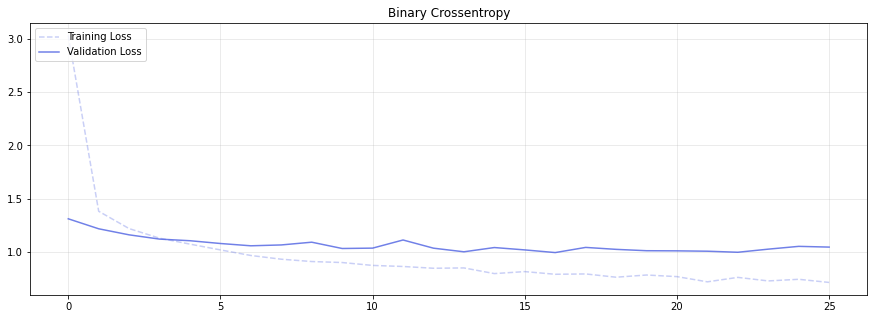

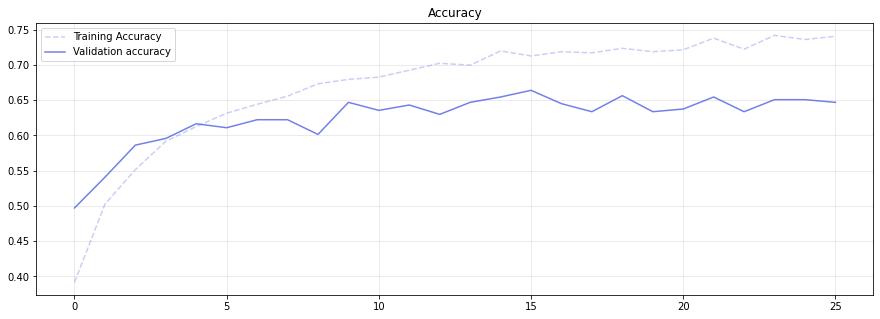

In [20]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [21]:
tl_model.save('Vgg19/tl_model_v1')

In [26]:
tl_model = tfk.models.load_model('Vgg19/tl_model_v1')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [27]:
tl_model.get_layer('vgg19').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_conv4 True
11 block3_pool True
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


In [28]:
for i, layer in enumerate(tl_model.get_layer('vgg19').layers[:15]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 


In [29]:
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [30]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen ,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=2 , restore_best_weights=True)],
    #class_weight = class_weight
).history

Epoch 1/200
175/175 [==============================] - 31s 172ms/step - loss: 1.3231 - accuracy: 0.5236 - precision_2: 0.6578 - recall_2: 0.3718 - val_loss: 0.9773 - val_accuracy: 0.6376 - val_precision_2: 0.7465 - val_recall_2: 0.5085
Epoch 2/200
175/175 [==============================] - 27s 153ms/step - loss: 0.9172 - accuracy: 0.6771 - precision_2: 0.7697 - recall_2: 0.5527 - val_loss: 0.8672 - val_accuracy: 0.7078 - val_precision_2: 0.7900 - val_recall_2: 0.5996
Epoch 3/200
175/175 [==============================] - 27s 153ms/step - loss: 0.7104 - accuracy: 0.7470 - precision_2: 0.8228 - recall_2: 0.6677 - val_loss: 0.8538 - val_accuracy: 0.7381 - val_precision_2: 0.8244 - val_recall_2: 0.6148
Epoch 4/200
175/175 [==============================] - 25s 143ms/step - loss: 0.6331 - accuracy: 0.7805 - precision_2: 0.8407 - recall_2: 0.7038 - val_loss: 0.8594 - val_accuracy: 0.7078 - val_precision_2: 0.7745 - val_recall_2: 0.6452
Epoch 5/200
175/175 [==============================] - 2

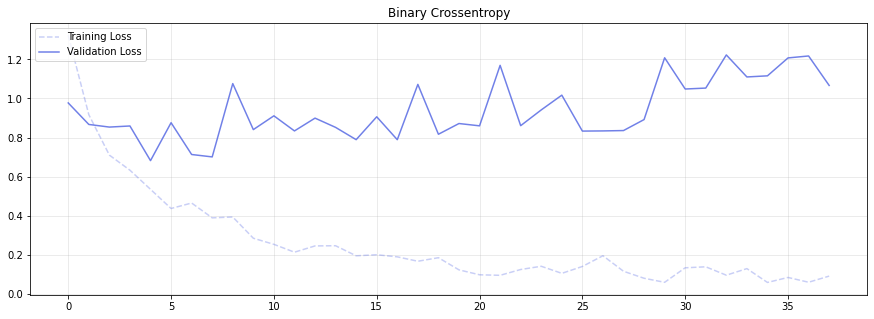

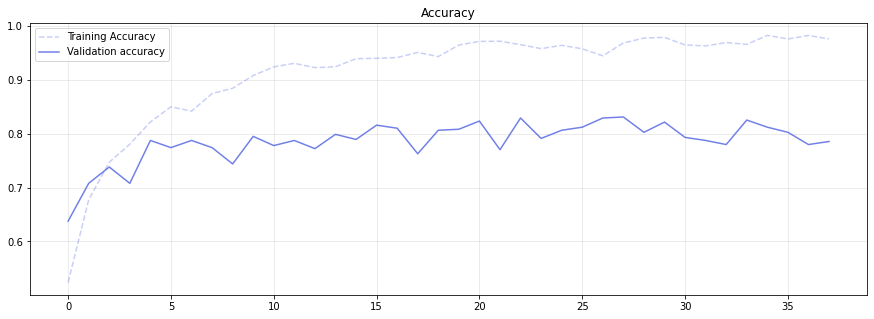

In [31]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [33]:
!ls

atMost200      atMost700.zip		      model.png
atMost300      atMost800		      Vgg16
atMost400      atMost800.zip		      vgg16_700samples.ipynb
atMost500      atMost900		      Vgg19
atMost500.zip  atMost900.zip		      vgg19_700samples.ipynb
atMost700      data_augmentation_experiments


In [34]:
tl_model.save('Vgg19/Tuned_15layers')

In [35]:
# Test the model
tl_model = tfk.models.load_model("Vgg19/Tuned_15layers")
model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)

12/12 [==============================] - 202s 18s/step - loss: 0.8037 - accuracy: 0.8199 - precision_2: 0.8509 - recall_2: 0.8061

Test metrics
{'loss': 0.8037052750587463, 'accuracy': 0.8199446201324463, 'precision_2': 0.8508771657943726, 'recall_2': 0.8060941696166992}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


Accuracy: 0.8199
Precision: 0.8081
Recall: 0.7947
F1: 0.7968


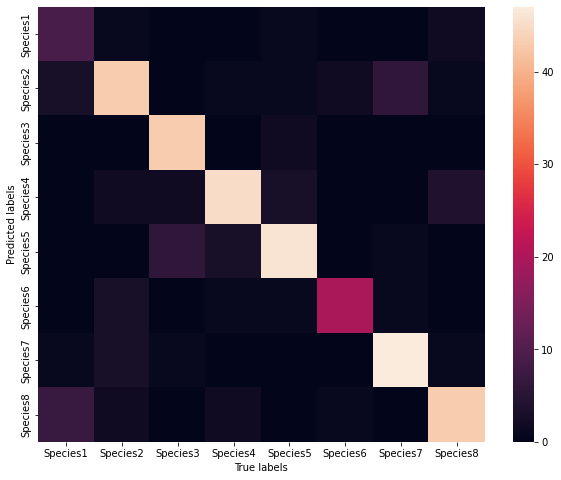

In [36]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()